# Proyek Analisis Sentimen

Install dan Import Library

In [1]:
%%capture
!pip install emoji
!pip install imblearn
!pip install keras
!pip install tensorflow
!pip install wordcloud

In [2]:
import emoji
import joblib
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string

from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from IPython.display import HTML

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN, Embedding, SpatialDropout1D, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Drop Missing Values

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset-brilliant.csv')

In [6]:
df = df.dropna()
print(df.shape)
print(df.isna().sum())
print(df.duplicated().sum())
df.head(3)

(14985, 2)
content    0
score      0
dtype: int64
0


,content,score
0,"Love the app, my one major complaint is that you guys change the course content and layout every couple of weeks. Some of us like to feel that we have fully ingested a chunk of content, and not to come back later to find that it has 20% more content now and I either have to spend an hour or two on a basic level course to satisfy my OCD that I have fully covered the fundamentals, or just assume that it wasnt important enough to have been originally included in the course from the start?",5
1,"I really enjoy the courses, but I have been having a small issue since a few updates back. When I leave the app and open it again, the loading screen shows and keeps loading until I quit the app and restart. This was not an issue a few months ago, and it is just very annoying.",4
2,"I was really liking this at first, but the lessons appear to jump from one topic to another (doing trig in geometry) with no real guidance. It also seems like the number of courses are diminishing rather than increasing. I was wanting in-depth math guidance from algebra to calculus to shore up my skills, but one gets a little of one topic before moving on to another in an unproductive fashion. Unless this vastly improves, my use of this and my continued subscription is ending.",1


Text Preprocessing

In [7]:
def cleaning(text):
    return re.sub(r'[^a-z\s]', '', text.lower())

def tokenizing(text):
    return word_tokenize(text)

def filtering(tokens):
    return [word for word in tokens if word not in set(stopwords.words('english'))]

def convertToSentence(tokens):
    return ' '.join(tokens)

def stemming(text):
    return ' '.join([SnowballStemmer('english').stem(word) for word in text.split()])

df['clean_content'] = df['content'].apply(cleaning).apply(tokenizing).apply(filtering).apply(convertToSentence)
df.head(3)

,content,score,clean_content
0,"Love the app, my one major complaint is that you guys change the course content and layout every couple of weeks. Some of us like to feel that we have fully ingested a chunk of content, and not to come back later to find that it has 20% more content now and I either have to spend an hour or two on a basic level course to satisfy my OCD that I have fully covered the fundamentals, or just assume that it wasnt important enough to have been originally included in the course from the start?",5,love app one major complaint guys change course content layout every couple weeks us like feel fully ingested chunk content come back later find content either spend hour two basic level course satisfy ocd fully covered fundamentals assume wasnt important enough originally included course start
1,"I really enjoy the courses, but I have been having a small issue since a few updates back. When I leave the app and open it again, the loading screen shows and keeps loading until I quit the app and restart. This was not an issue a few months ago, and it is just very annoying.",4,really enjoy courses small issue since updates back leave app open loading screen shows keeps loading quit app restart issue months ago annoying
2,"I was really liking this at first, but the lessons appear to jump from one topic to another (doing trig in geometry) with no real guidance. It also seems like the number of courses are diminishing rather than increasing. I was wanting in-depth math guidance from algebra to calculus to shore up my skills, but one gets a little of one topic before moving on to another in an unproductive fashion. Unless this vastly improves, my use of this and my continued subscription is ending.",1,really liking first lessons appear jump one topic another trig geometry real guidance also seems like number courses diminishing rather increasing wanting indepth math guidance algebra calculus shore skills one gets little one topic moving another unproductive fashion unless vastly improves use continued subscription ending


In [9]:
df.drop_duplicates(subset='clean_content', inplace=True)
print(df['clean_content'].duplicated().sum())
df.shape

0


(13379, 3)

Distribusi Skor Review dan Wordcloud

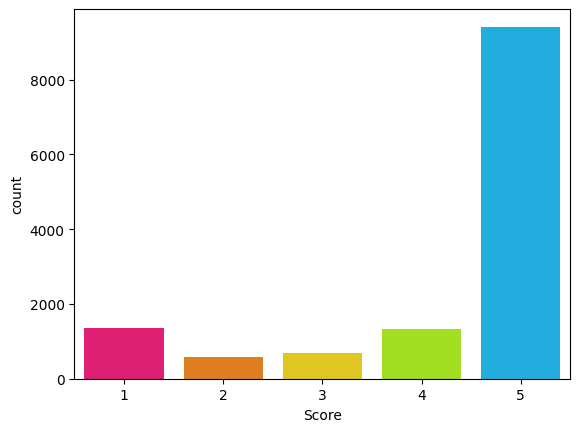

In [13]:
sns.countplot(x='score', data=df, hue='score', palette=["#FF006D", "#FF7D00", "#FFDD00", "#ADFF02", "#01BEFE"], dodge=False)
plt.xlabel('Score')
plt.legend([],[], frameon=False)
plt.show()

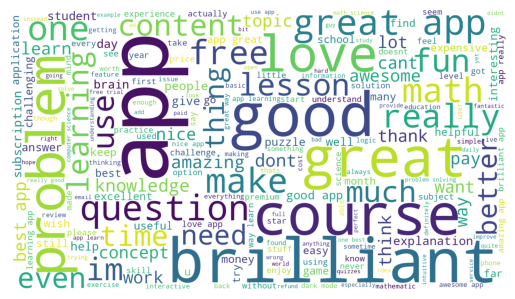

In [14]:
plt.imshow(WordCloud(width=1920, height=1080, background_color='white').generate(' '.join(df['clean_content'])), interpolation='antialiased')
plt.axis('off')
plt.show()

In [15]:
from collections import Counter
def plot_top_words(texts):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(50)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(24, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

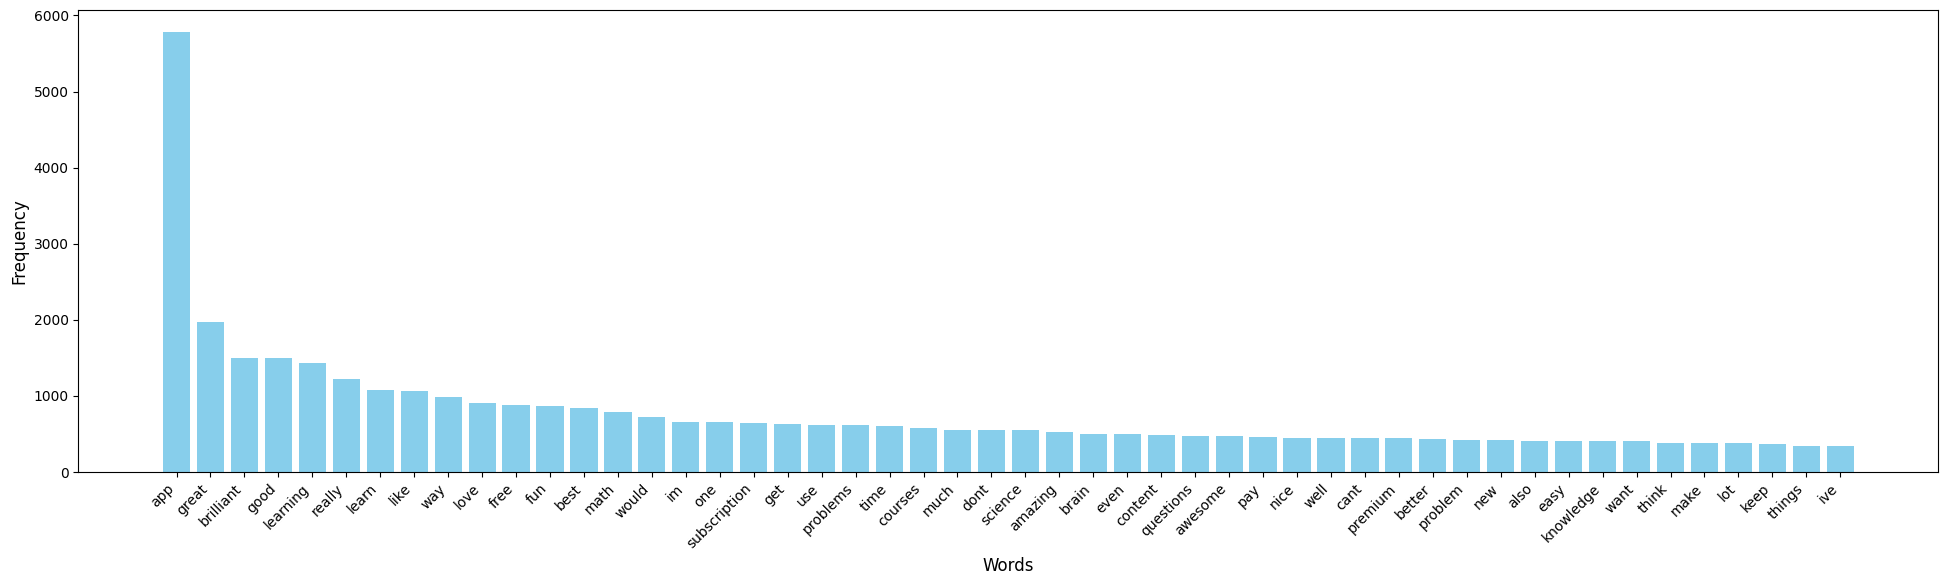

In [16]:
plot_top_words(df['clean_content'])

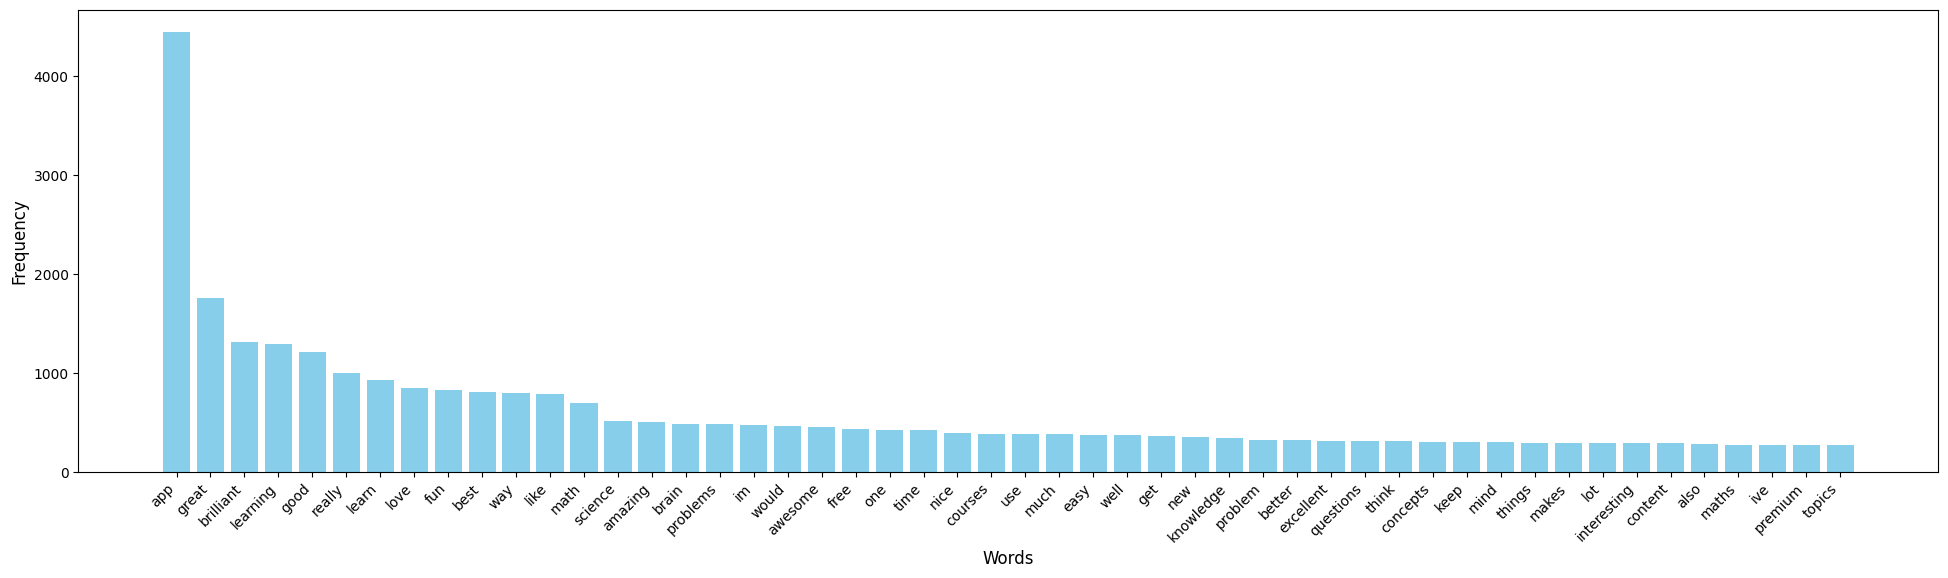

In [17]:
plot_top_words(df[df['score'].isin([4, 5])]['clean_content'])

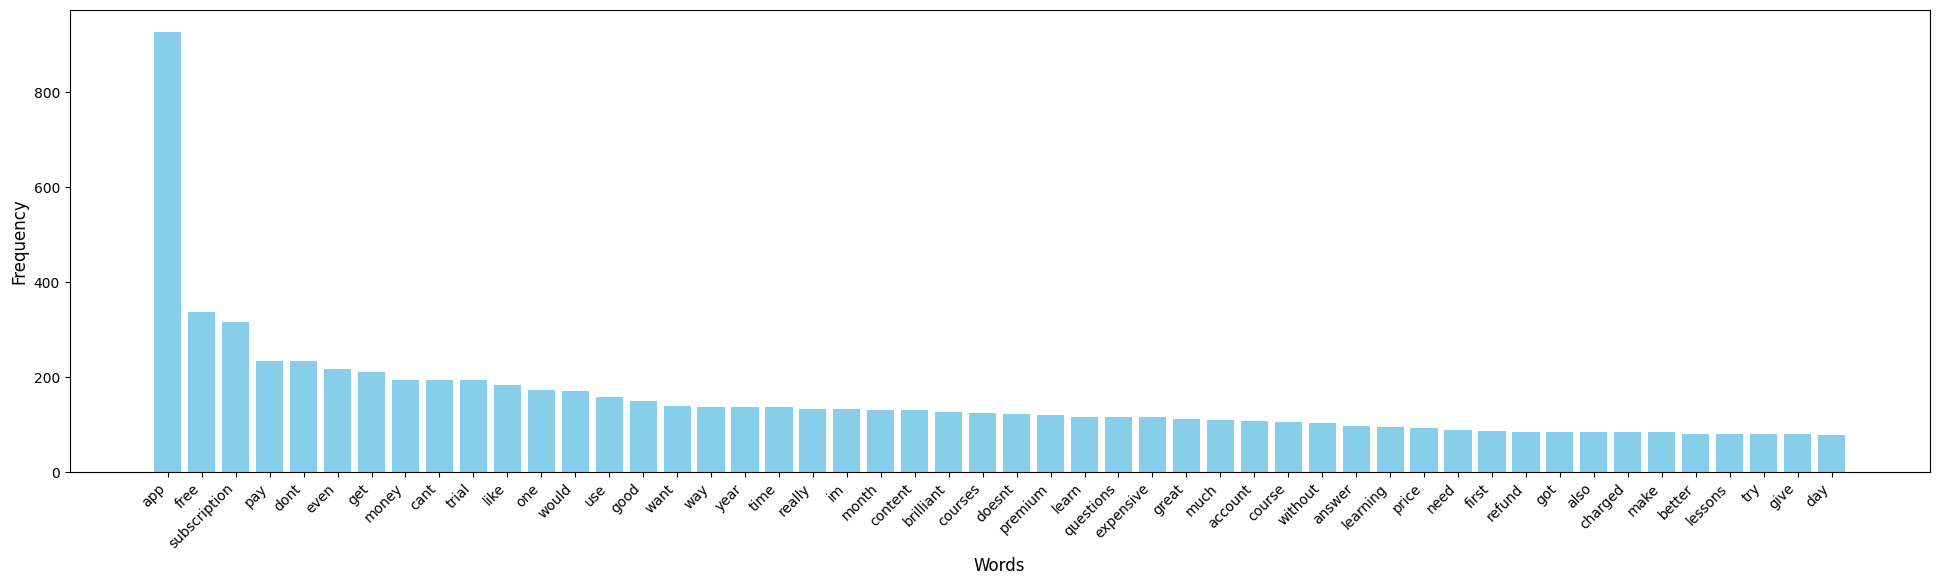

In [18]:
plot_top_words(df[df['score'].isin([1, 2])]['clean_content'])

In [19]:
def Label(text):
    positive_keywords = ['great', 'good', 'love', 'loving', 'fun', 'best', 'amazing',
                         'nice', 'easy', 'excellent', 'interesting', 'useful', 'recommended',
                         'worth', 'enjoy', 'fantastic', 'interactive', 'thank', 'thanks',
                         'satisfy', 'high', 'helpful']
    negative_keywords = ['free', 'pay', 'dont', 'money', 'cant', 'trial', 'doesnt',
                         'expensive', 'need', 'ads', 'still', 'price', 'refund', 'try',
                         'still', 'wont', 'paid', 'wrong', 'charge', 'cancel', 'bug',
                         'payment', 'payments', 'unreliable', 'loading', 'troubleshooting',
                         'please', 'problem', 'problems', 'service', 'didnt', 'tried',
                         'stupid', 'annoying', 'error']
    text_lower = text.lower()
    if any(keyword in text_lower for keyword in positive_keywords):
        return 'positive'
    elif any(keyword in text_lower for keyword in negative_keywords):
        return 'negative'
    else:
        return 'neutral'
df['label'] = df['clean_content'].apply(Label)
print(df.shape)
df.head(3)

(13379, 4)


,content,score,clean_content,label
0,"Love the app, my one major complaint is that you guys change the course content and layout every couple of weeks. Some of us like to feel that we have fully ingested a chunk of content, and not to come back later to find that it has 20% more content now and I either have to spend an hour or two on a basic level course to satisfy my OCD that I have fully covered the fundamentals, or just assume that it wasnt important enough to have been originally included in the course from the start?",5,love app one major complaint guys change course content layout every couple weeks us like feel fully ingested chunk content come back later find content either spend hour two basic level course satisfy ocd fully covered fundamentals assume wasnt important enough originally included course start,positive
1,"I really enjoy the courses, but I have been having a small issue since a few updates back. When I leave the app and open it again, the loading screen shows and keeps loading until I quit the app and restart. This was not an issue a few months ago, and it is just very annoying.",4,really enjoy courses small issue since updates back leave app open loading screen shows keeps loading quit app restart issue months ago annoying,positive
2,"I was really liking this at first, but the lessons appear to jump from one topic to another (doing trig in geometry) with no real guidance. It also seems like the number of courses are diminishing rather than increasing. I was wanting in-depth math guidance from algebra to calculus to shore up my skills, but one gets a little of one topic before moving on to another in an unproductive fashion. Unless this vastly improves, my use of this and my continued subscription is ending.",1,really liking first lessons appear jump one topic another trig geometry real guidance also seems like number courses diminishing rather increasing wanting indepth math guidance algebra calculus shore skills one gets little one topic moving another unproductive fashion unless vastly improves use continued subscription ending,negative


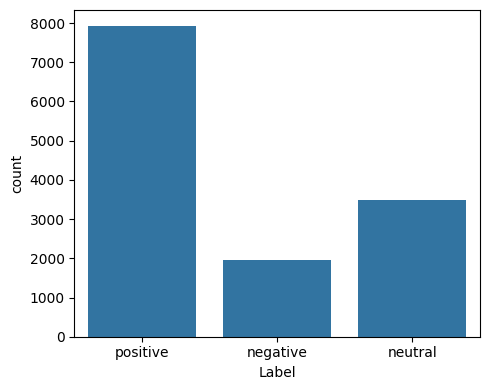

In [21]:
fig, axs = plt.subplots(figsize=(5, 4))
sns.countplot(x='label', data=df, dodge=False)
axs.set_xlabel('Label')
plt.tight_layout()
plt.show()

Labelling

In [22]:
def map_labels(label):
    mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    return mapping[label]

df['label'] = df['label'].apply(map_labels)

In [23]:
df.head(3)

,content,score,clean_content,label
0,"Love the app, my one major complaint is that you guys change the course content and layout every couple of weeks. Some of us like to feel that we have fully ingested a chunk of content, and not to come back later to find that it has 20% more content now and I either have to spend an hour or two on a basic level course to satisfy my OCD that I have fully covered the fundamentals, or just assume that it wasnt important enough to have been originally included in the course from the start?",5,love app one major complaint guys change course content layout every couple weeks us like feel fully ingested chunk content come back later find content either spend hour two basic level course satisfy ocd fully covered fundamentals assume wasnt important enough originally included course start,2
1,"I really enjoy the courses, but I have been having a small issue since a few updates back. When I leave the app and open it again, the loading screen shows and keeps loading until I quit the app and restart. This was not an issue a few months ago, and it is just very annoying.",4,really enjoy courses small issue since updates back leave app open loading screen shows keeps loading quit app restart issue months ago annoying,2
2,"I was really liking this at first, but the lessons appear to jump from one topic to another (doing trig in geometry) with no real guidance. It also seems like the number of courses are diminishing rather than increasing. I was wanting in-depth math guidance from algebra to calculus to shore up my skills, but one gets a little of one topic before moving on to another in an unproductive fashion. Unless this vastly improves, my use of this and my continued subscription is ending.",1,really liking first lessons appear jump one topic another trig geometry real guidance also seems like number courses diminishing rather increasing wanting indepth math guidance algebra calculus shore skills one gets little one topic moving another unproductive fashion unless vastly improves use continued subscription ending,0


**Machine Learning**: Logistic Regression, Random Forest, SVM

In [26]:
X = df['clean_content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
results = []
models = {'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', multi_class='ovr', random_state=42),
          'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
          'SVM': SVC(kernel='linear', C=1.0, decision_function_shape='ovr', random_state=42)}
sampling_methods = {'SMOTE': SMOTE(random_state=42),
                    'Random Under Sampling': RandomUnderSampler(random_state=42)}
vectorizers = {'TF-IDF': TfidfVectorizer(max_features=200, min_df=17, max_df=0.8),
               'CountVectorizer': CountVectorizer(max_features=200, min_df=17, max_df=0.8)}
for model_name, model in models.items():
    for sampling_name, sampler in sampling_methods.items():
        for vectorizer_name, vectorizer in vectorizers.items():
            steps = [('vectorizer', vectorizer)]
            if sampler:
                steps.append(('sampling', sampler))
            steps.append(('classifier', model))
            pipeline = imPipeline(steps)
            pipeline.fit(X_train, y_train)
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
            accuracy_train = accuracy_score(y_train, y_pred_train)
            accuracy_test = accuracy_score(y_test, y_pred_test)
            results.append({'Model': model_name,
                            'Sampling Method': sampling_name,
                            'Vectorizer': vectorizer_name,
                            'Accuracy Train': accuracy_train,
                            'Accuracy Test': accuracy_test})
print(f'Number of classes: {len(y.unique())}')
pd.DataFrame(results)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Number of classes: 3


,Model,Sampling Method,Vectorizer,Accuracy Train,Accuracy Test
0,Logistic Regression,SMOTE,TF-IDF,0.925894,0.913054
1,Logistic Regression,SMOTE,CountVectorizer,0.936466,0.925262
2,Logistic Regression,Random Under Sampling,TF-IDF,0.901228,0.891878
3,Logistic Regression,Random Under Sampling,CountVectorizer,0.936038,0.924016
4,Random Forest,SMOTE,TF-IDF,0.851148,0.848281
5,Random Forest,SMOTE,CountVectorizer,0.885745,0.876183
6,Random Forest,Random Under Sampling,TF-IDF,0.849867,0.848530
7,Random Forest,Random Under Sampling,CountVectorizer,0.852429,0.849278
8,SVM,SMOTE,TF-IDF,0.943300,0.932985
9,SVM,SMOTE,CountVectorizer,0.942338,0.937469


**Deep Learning**: LSTM, BiLSTM


In [28]:
X = df['clean_content']
y = df['label']
num_classes = len(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
results = []

tokenizer = Tokenizer(num_words=5000, oov_token='')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

def create_model(model_type, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
    if model_type == 'LSTM':
        model.add(LSTM(128))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model_types = ['LSTM', 'BiLSTM']
for model_type in model_types:
    print(f'\nTraining {model_type} model...')
    model = create_model(model_type, num_classes)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train_padded, y_train_categorical,
                        epochs=10, batch_size=32,
                        validation_data=(X_test_padded, y_test_categorical),
                        callbacks=[early_stop], verbose=2)
    train_loss, train_accuracy = model.evaluate(X_train_padded, y_train_categorical, verbose=2)
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_categorical, verbose=2)
    results.append({'Model': model_type,
                    'Accuracy Train': train_accuracy,
                    'Accuracy Test': test_accuracy})
print(f'Number of classes: {num_classes}')
results_df = pd.DataFrame(results)
print(results_df)


Training LSTM model...
Epoch 1/10
293/293 - 59s - 202ms/step - accuracy: 0.5926 - loss: 0.9515 - val_accuracy: 0.5927 - val_loss: 0.9489
Epoch 2/10
293/293 - 57s - 194ms/step - accuracy: 0.5935 - loss: 0.9478 - val_accuracy: 0.5927 - val_loss: 0.9435
Epoch 3/10
293/293 - 80s - 271ms/step - accuracy: 0.5935 - loss: 0.9471 - val_accuracy: 0.5927 - val_loss: 0.9439
Epoch 4/10
293/293 - 83s - 285ms/step - accuracy: 0.5935 - loss: 0.9453 - val_accuracy: 0.5927 - val_loss: 0.9441
Epoch 5/10
293/293 - 83s - 282ms/step - accuracy: 0.5935 - loss: 0.9443 - val_accuracy: 0.5927 - val_loss: 0.9450
293/293 - 16s - 53ms/step - accuracy: 0.5935 - loss: 0.9412
126/126 - 6s - 46ms/step - accuracy: 0.5927 - loss: 0.9435

Training BiLSTM model...
Epoch 1/10
293/293 - 110s - 374ms/step - accuracy: 0.8202 - loss: 0.4599 - val_accuracy: 0.9312 - val_loss: 0.2044
Epoch 2/10
293/293 - 141s - 482ms/step - accuracy: 0.9744 - loss: 0.1001 - val_accuracy: 0.9731 - val_loss: 0.1017
Epoch 3/10
293/293 - 143s - 487

In [29]:
!pip freeze > requirements.txt

# **Kesimpulan**

- Dataset terdiri dari **13,379 sampel data** dengan **3 kelas target** yang menunjukkan bahwa data cukup besar untuk melatih model klasifikasi dengan baik.
- Penggunaan **CountVectorizer** menghasilkan akurasi yang sedikit lebih baik dibandingkan **TF-IDF** dalam sebagian besar kombinasi.
- Teknik sampling seperti **SMOTE** memberikan hasil yang lebih baik dibandingkan **Random Under Sampling**
- **BiLSTM** adalah model terbaik secara keseluruhan, dengan akurasi tertinggi (**97.31%**) di antara semua model yang diuji.

# **Rekomendasi**
1. Gunakan **BiLSTM** untuk akurasi tertinggi dan performa terbaik pada dataset serupa.
2. Jika memilih model Machine Learning, gunakan **SVM dengan CountVectorizer dan SMOTE** untuk hasil yang mendekati Deep Learning dengan waktu pelatihan yang lebih singkat.